### Imports

In [10]:
% matplotlib inline
import os
import sys
sys.path.append('../..')
os.chdir('../..')
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io as io
from io import BytesIO
from IPython.display import Image
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
import menpo.io as mio
import tensorflow as tf
from menpo.visualize import print_progress
from project.utils import tfrecords
import predict_lv as predict
import project.utils.visualisation as visualisation

import menpo.io as mio
import menpo.visualize
from menpowidgets import visualize_images

from pathlib import Path

In [16]:

""" Functions for writing TFRecord features """


def _int_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def get_jpg_string(image):
    # Gets the serialized jpg from a menpo `Image`.
    fp = BytesIO()
    mio.export_image(image, fp, extension='jpg')
    fp.seek(0)
    return fp.read()
def face_iterator(images):
    """ Given an iterable of images, returns a generator of cat face data """
    #for idx, img in enumerate(print_progress(images, end_with_newline=False)):
    img = images
    image_name = img.path.name

    yield image_name, img


def generate(iterator,
             store_path='./',
             record_name='inference.tfrecords',
             store_records=True):
    store_path = Path(store_path)

    if store_records:
        writer = tf.python_io.TFRecordWriter(str(store_path / record_name))

    for img_name, pimg in iterator:
        
        # resize image to 256 * 256
        cimg = pimg.resize([256, 256])

        img_path = store_path / '{}'.format(img_name)
        #print(cimg.shape)
        if store_records:
            try:
                # construct the Example proto object
                example = tf.train.Example(
                    features=tf.train.Features(
                        # Features contains a map of string to Feature proto objects
                        feature={
                            # images
                            'image': tfrecords.bytes_feature(get_jpg_string(cimg)),
                            'height': tfrecords.int_feature(cimg.shape[0]),
                            'width': tfrecords.int_feature(cimg.shape[1]),
                        }))
                # use the proto object to serialize the example to a string
                serialized = example.SerializeToString()
                # write the serialized object to disk
                writer.write(serialized)

            except Exception as e:
                print('Something bad happened when processing image: "{}"'.format(img_name))
                print(e)

    if store_records:
        writer.close()


# where should the resulting TFRecords files be written to?
store_path = Path('I:/menpo/project_lv/data/images')
inference_record_name = "temp.tfrecords"
image = mio.import_image('I:/menpo/project_lv/data/images/2564.jpg')
image= image.resize([256, 256])

#print('Found {} assets'.format(len(images)))

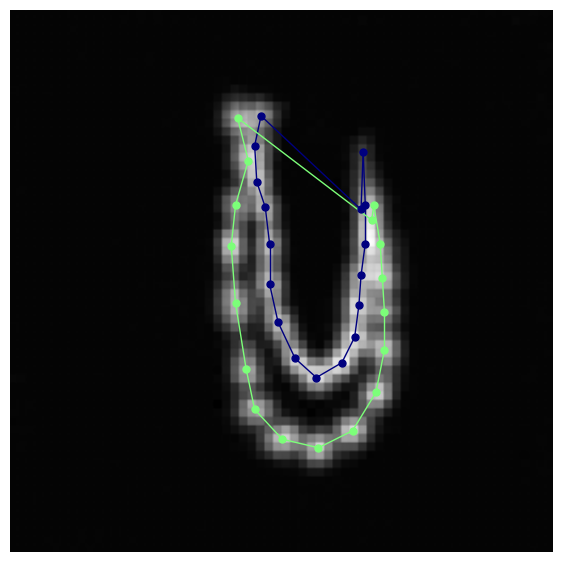

In [15]:
# Predictions is a `dict`, containing a set of input 'images' and their corresponding 'heatmaps' and 'coordinates'

import project.hourglass.params as hgparams
from menpo.feature import *
params = {
    hgparams.N_FEATURES: 128,
    hgparams.N_HOURGLASS: 1,
    hgparams.N_RESIDUALS: 3,
}
@imgfeature
def hg(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    # generate TFRecords
    generate(face_iterator(image), store_path, inference_record_name,
         store_records=True)
    # Where is the model located?
    model_dir = Path('I:/menpo/project_lv/models/lv/lv_1hg_lr1e-3_decay10')

    # Where are the .tfrecords?
    infer_data_dir = Path('I:/menpo/project_lv/data/images/')
    infer_tfrecords = 'temp.tfrecords'

    infer_data = infer_data_dir / infer_tfrecords
    
    predictions = predict.predict(str(model_dir), str(infer_data), params)
    images_generator = visualisation.lv_predictions(predictions,
                                           show_input_images=True,
                                           show_combined_heatmap=True,
                                           show_individual_heatmaps=False)
    images = menpo.base.LazyList.init_from_iterable(images_generator)
    flatten = lambda list_of_lists: [item for sublist in list_of_lists for item in sublist]
    images = flatten(images)
    return  images[1]


visualize_images(hg(image))

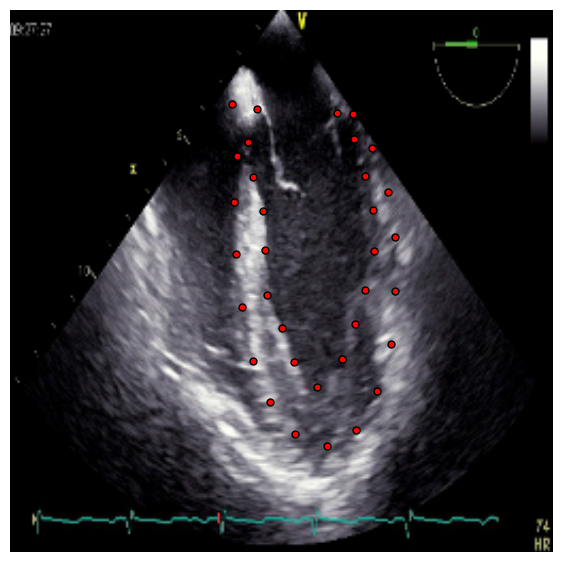

In [17]:
visualize_images(image, browser_style='buttons')

### Save the results!

###### Save as .mp4

In [6]:
# Export as Video
video_path = infer_data_dir / (infer_data.stem + "_" + model_dir.stem + "_predictions.mp4")

print('Exporting video to {}'.format(video_path))

def rasterise(image):
    rasterised_image = image.rasterize_landmarks(group='lv_34')    
    return rasterised_image

# images_with_landmarks = images.map(rasterise)
# images_with_landmarks = map(rasterise, images)
images_with_landmarks = [rasterise(image) for image in images]

mio.export_video(images_with_landmarks, video_path,
                fps=1)

print('Exported video to {}'.format(video_path))

Exporting video to data\images\inference_lv_1hg_lr1e-3_decay10_predictions.mp4
Exported video to data\images\inference_lv_1hg_lr1e-3_decay10_predictions.mp4


###### Save as pickle
These can be reloaded for later use e.g. for fitting deformable models...

In [6]:
pickle_path = infer_data_dir / (infer_data.stem + "_" + model_dir.stem + "_predictions.pkl")
print('Saving predictions to {}...'.format(pickle_path))

mio.export_pickle(images, pickle_path, overwrite=True, protocol=2)

print('Saved predictions to {}'.format(pickle_path))

Saving predictions to data\images\inference_lv_1hg_lr1e-3_decay10_predictions.pkl...
Saved predictions to data\images\inference_lv_1hg_lr1e-3_decay10_predictions.pkl
